## Project Submission

Please fill out:
* Student name: Daniel Bradley and Monica Haderthauer
* Student pace: full time
* Scheduled project review date/time: 03/31/2022
* Instructor name: Praveen Gowtham
* Blog post URL: https://github.com/DanlBradley/Phase2Project


In [4]:
# Your code here - remember to use markdown cells for comments as well!
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

## Initial inspection and cleaning
- Clean up DataFrame, drop NaN entries if there is sufficient data, and look for NaN entries that go under a placeholder name
- Split DataFrame into numerics and categorical variables
- Basic feature engineering such as 'price / sqfoot' column and 'renovated vs. not renovated' column

In [5]:
#Create housing dataframe
df = pd.read_csv('data/kc_house_data.csv')
#Clean up NaNs
df['sqft_basement'] = df['sqft_basement'].replace('?',np.nan)
df.drop(columns = 'sqft_lot15')
df = df.dropna()


#Convert date string to datetime
df['date'] = pd.to_datetime(df['date'])


#Convert sqft_basement to a float
df['sqft_basement'] = df['sqft_basement'].apply(lambda x: float(x))


#Add categorical column "renovated" vs "not renovated"
df['renovated_status'] = df['yr_renovated'].apply(lambda x: 'NO' if x == 0 else 'YES')


#Add a price / sqfoot column
df['price_per_sqfoot'] = df['price'] / df['sqft_above']

In [6]:
#Create dataframe for just numerics
df_numerics = df.select_dtypes(include = np.number, exclude = object)

#Select a target metric to compare other columns to
target_metric = 'price_per_sqfoot'

In [7]:
#Create a categorical dataframe
df_cat = df[['waterfront','view','condition','grade','renovated_status']]

In [8]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
y = df_numerics[target_metric]
x = sm.add_constant(df_numerics.drop(columns=[target_metric,'id','yr_renovated','zipcode','sqft_lot15']))
model = sm.OLS(y,x).fit()

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


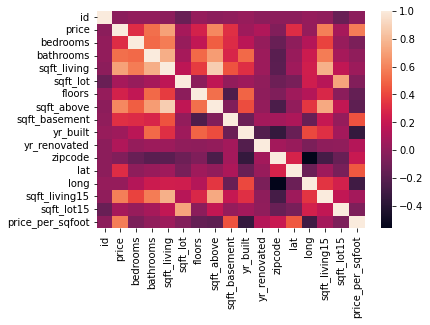

In [9]:
import seaborn as sns

#Correlation matrix
Var_Corr = df_numerics.corr()
# plot the heatmap and annotation on it
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=False);

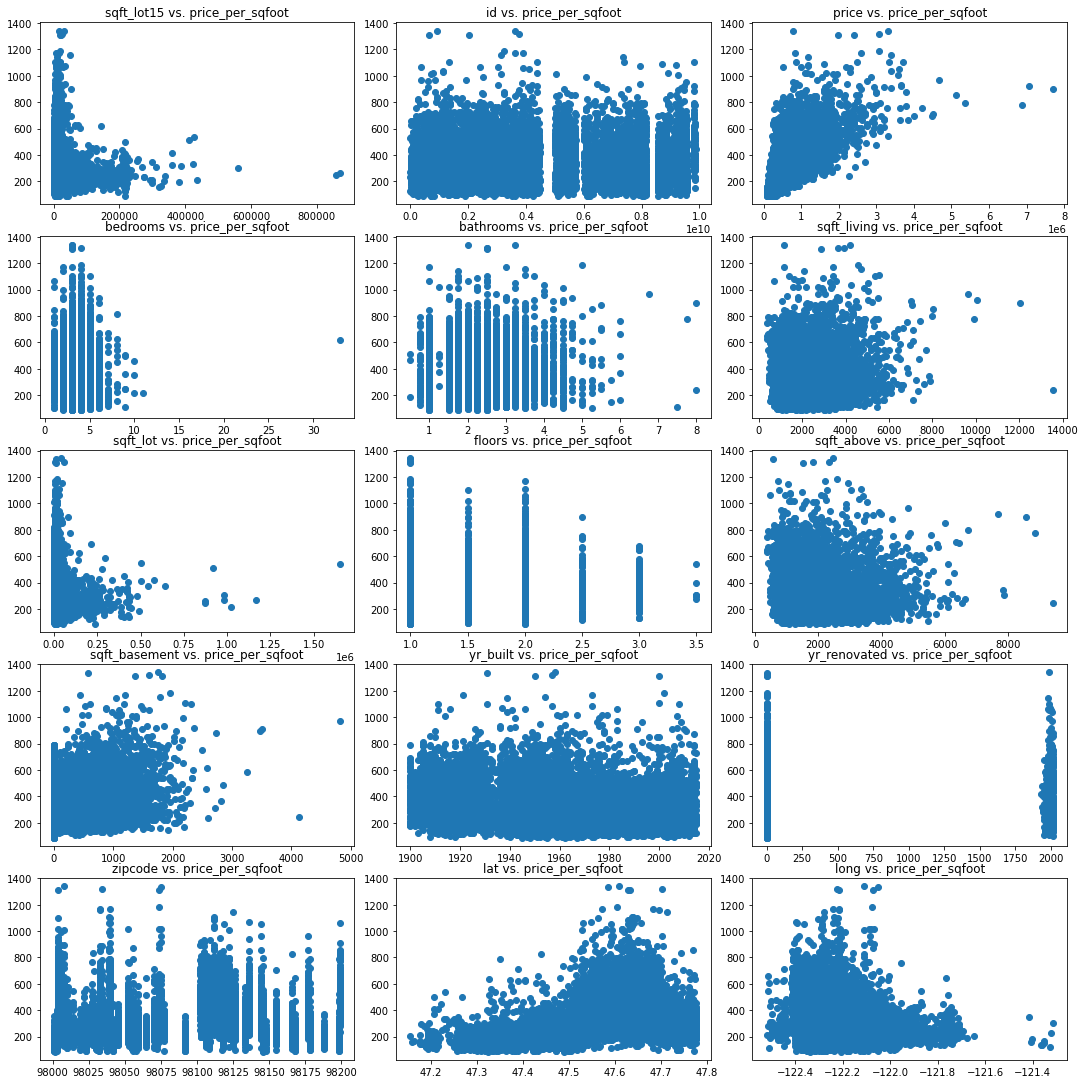

In [10]:
fig, axs = plt.subplots(5,3)


fig.set_figheight(15)
fig.set_figwidth(15)
plt.tight_layout()
independants = df_numerics.drop(columns=target_metric)
dependant = df_numerics[target_metric]
column_num = 0

for i in range(5):
    for j in range(3):
        axs[i,j].scatter(independants.iloc[:,(column_num-1)],dependant)
        axs[i,j].set_title('{} vs. {}'.format(independants.columns[column_num-1], target_metric))
        column_num += 1

In [13]:
import folium
df_renovated = df_numerics.loc[df_numerics['yr_renovated'] != 0]
lat = df_renovated['lat']
long = df_renovated['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=13)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map;


## Combining seattle AirBNB data with seattle housing data 
- Determine a predictive model for homes doing well in airbnb vs. the housing data
- Then make inferences about what to look for in a home when buying as an AirBNB investment

In [14]:
bnb_listings = pd.read_csv('data/earnings_data.csv')

#Renaming columns so they can be merged properly
bnb_listings['longitude'] = round(bnb_listings['longitude'],3)
bnb_listings['long'] = round(bnb_listings['longitude'],3)
bnb_listings['latitude'] = round(bnb_listings['latitude'],3)
bnb_listings['lat'] = round(bnb_listings['latitude'],3)

In [20]:
merged = df.merge(bnb_listings, how = 'inner', on = ['long','lat'])

In [21]:
lat = merged['lat'] #Folium map
long = merged['long']

#Create a map of the area
base_map = folium.Map([lat.mean(), long.mean()], zoom_start=12)

for lat1,long1 in zip(lat,long):
     popup_text = 'Lat: {} \n Long: {}'.format(lat1,long1)
     popup = folium.Popup(popup_text, parse_html=True)
     marker = folium.Marker(location=[lat1, long1], popup = popup)
     marker.add_to(base_map)
     
base_map;

In [22]:
#Look at numerical columns
merged_numerics = merged.select_dtypes(include = np.number, exclude = object)
merged_numerics = merged_numerics.dropna()

(68, 39)

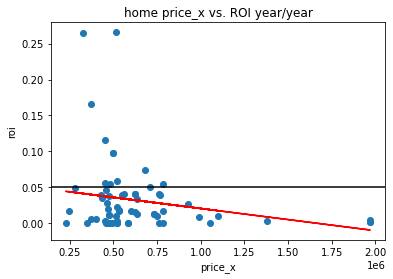

In [26]:
#Parameterized cell to let you scatter two variables from merged_numerics

#roi is a feature that lets you measure the performance of an airbnb listing. A common benchmark is 5% ROI.
merged_numerics['roi'] = (merged_numerics['earnings_per_mo'] * 12) / merged_numerics['price_x']
#merged_numerics = merged_numerics.drop(columns = 'avg_earnings')
fig, ax = plt.subplots()
x = merged_numerics['price_x']
y = merged_numerics['roi']
m,b = np.polyfit(x = x, y = y, deg = 1)
plt.scatter(x,y)
plt.xlabel(x.name)
plt.ylabel(y.name)
plt.title('home {} vs. ROI year/year'.format(x.name))
plt.plot(x,x*m+b, c= 'r')
plt.axhline(.05, c = 'black');


In [1]:
#Make a multiple linear regression model to check parameters performance on predicting target metric (chosen above in cell 3)
bnb_metric = 'roi'

#Filter out variables above a critical p-value
# pcrit = .3
# pvals = model.pvalues.to_dict()
# drop_list = []
# for key,val in pvals.items():
#     if val > pcrit:
#         drop_list.append(key)

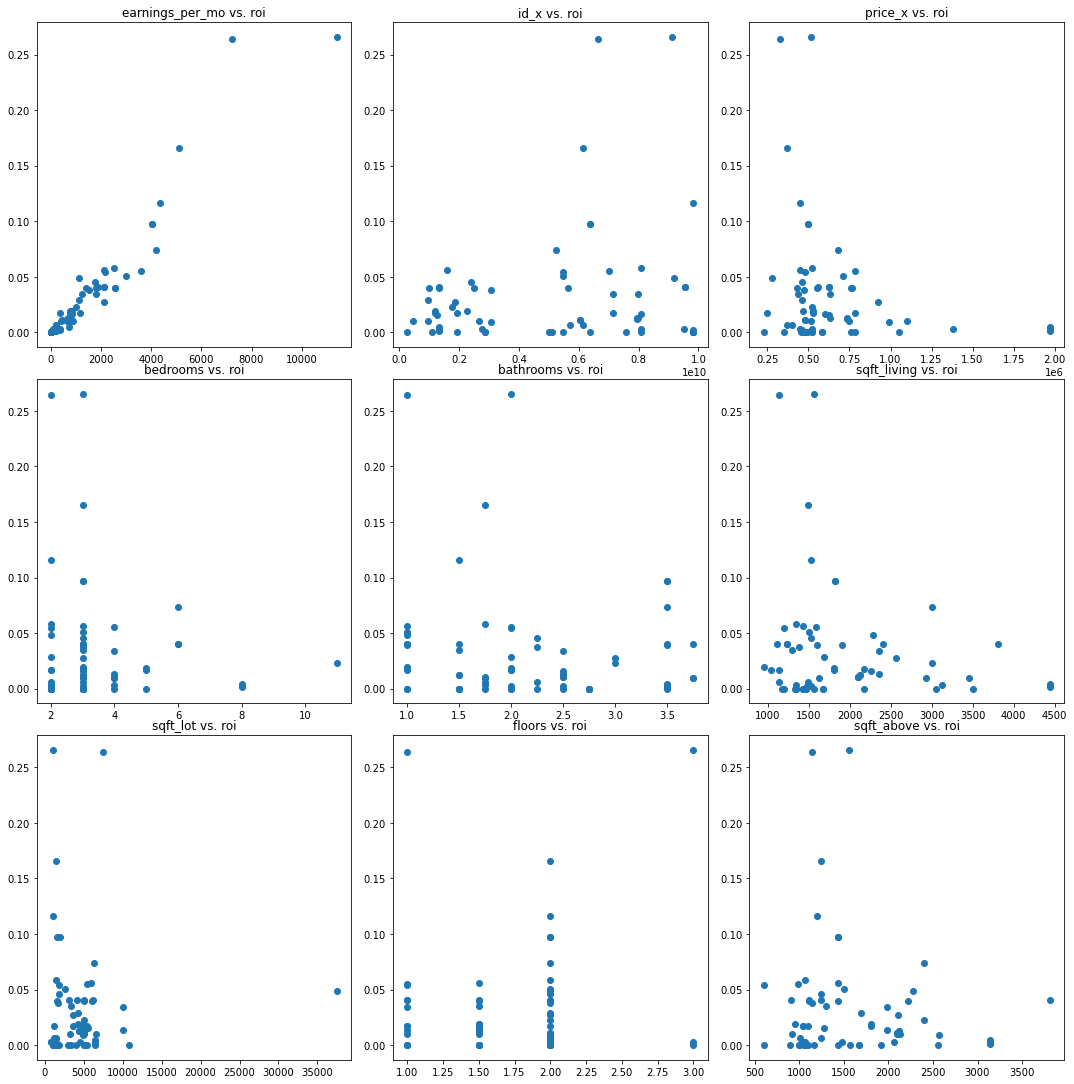

In [27]:
fig, axs = plt.subplots(3,3)
bnb_metric = 'roi'
fig.set_figheight(15)
fig.set_figwidth(15)
plt.tight_layout()
independants = merged_numerics.drop(columns=bnb_metric)
dependant = merged_numerics[bnb_metric]
column_num = 0

for i in range(3):
    for j in range(3):
        axs[i,j].scatter(independants.iloc[:,(column_num-1)],dependant)
        axs[i,j].set_title('{} vs. {}'.format(independants.columns[column_num-1], bnb_metric))
        column_num += 1

## Interpret results above
I view the results above as showing that the combination of reviews

In [65]:
#look at homes that have a high ROI
successful_units = merged_numerics.loc[merged_numerics['roi'] > .03]

In [66]:
successful_units.rename(columns = {'latitude': 'Latitude', 'long': 'Longitude'},inplace=True)

/Users/danielbradley/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [69]:
#This cell taken from Dave Fisher-Hickey from Kaggle guide: How to: Folium for maps, heatmaps & time data
#https://www.kaggle.com/code/daveianhickey/how-to-folium-for-maps-heatmaps-time-data/notebook
df_acc = successful_units

from folium import plugins
from folium.plugins import HeatMap


map_hooray = folium.Map(location=[df_acc['Latitude'].mean(), df_acc['Longitude'].mean()],
                    zoom_start = 12) 

# Ensure you're handing it floats
#df_acc['Latitude'] = df_acc['Latitude'].astype(float)
#df_acc['Longitude'] = df_acc['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs
heat_df = df_acc[['Latitude', 'Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data).add_to(map_hooray)

# Display the map
map_hooray



In [71]:
#Look at categorical columns
merged_cats = merged.select_dtypes(include = object, exclude = np.number)
merged_cats.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 68 entries, 0 to 67
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   waterfront                    68 non-null     object
 1   view                          68 non-null     object
 2   condition                     68 non-null     object
 3   grade                         68 non-null     object
 4   renovated_status              68 non-null     object
 5   street                        68 non-null     object
 6   neighbourhood_cleansed        68 non-null     object
 7   neighbourhood_group_cleansed  68 non-null     object
 8   city                          68 non-null     object
 9   state                         68 non-null     object
 10  zipcode_y                     68 non-null     object
 11  market                        68 non-null     object
 12  smart_location                68 non-null     object
 13  country_code          